# Brute force computation

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Blastoise`


In [3]:
using Plots
using QuadGK
using NPZ
using Interpolations
using DataInterpolations
using LaTeXStrings
using FastChebInterp
using Tullio
using SpecialFunctions
using ProgressMeter
using Blast

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: target mismatch (2))
ERROR: LoadError: SystemError: futimes: Permission denied
Stacktrace:
  [1] systemerror(p::Symbol, errno::Int32; extrainfo::Nothing)
    @ Base ./error.jl:176
  [2] systemerror
    @ ./error.jl:175 [inlined]
  [3] touch
    @ ./filesystem.jl:361 [inlined]
  [4] touch(path::String)
    @ Base.Filesystem ./file.jl:460
  [5] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String, build_id::UInt128, stalecheck::Bool; reasons::Dict{String, Int64}, DEPOT_PATH::Vector{String})
    @ Base ./loading.jl:2017
  [6] _require(pkg::Base.PkgId, env::String)
    @ Base ./loading.jl:2527
  [7] __require_prelocked(uuidkey::Base.PkgId, env::String)
    @ Base ./loading.jl:2388
  [8] #invoke_in_world#3
    @ ./essentials.jl:1089 [inlined]
  [9] invoke_in_world
    @ ./essentials.jl:1086 [inlined]
 [10] _require_prelocked(uuidkey::Base.PkgId, env::String)
    @ Base ./loading.jl:2375
 [11] mac

LoadError: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to "/home/schiarenza/.julia/compiled/v1.11/Plots/jl_VTh2dZ".

In [3]:
pk_lin = npzread("data/camb_lin_pk.npz")["arr_0"]
p0lin = pk_lin[1,:]
z = npzread("data/z_nl.npz")["arr_0"]
k = npzread("data/k_nl.npz")["arr_0"];

In [4]:
chi_finer = npzread("data/chi_finer.npz")["arr_0"]
cmb_kernel = npzread("data/ccl_cmb_kernel_finer.npz")["arr_0"]
gal_kernel = npzread("data/ccl_gal_kernel_finer.npz")["arr_0"]
sh_kernel = npzread("data/ccl_sh_kernel_finer.npz")["arr_0"]
growth = npzread("data/growth_finer.npy");

## Inner χ integrals

In [5]:
D_chi = AkimaInterpolation(growth, chi_finer, extrapolate=true)
K_g = AkimaInterpolation(gal_kernel, chi_finer, extrapolate=true)
K_s = AkimaInterpolation(sh_kernel, chi_finer, extrapolate=true)
K_cmb = AkimaInterpolation(cmb_kernel, chi_finer, extrapolate=true);


In [6]:
function f_g(x, k, l)
    return @. D_chi(x)*K_g(x)*SpecialFunctions.sphericalbesselj.(l, x * k)
end

function f_s(x, k, l)
    return @. D_chi(x)*K_s(x)*SpecialFunctions.sphericalbesselj.(l, x * k)/(k*x)^2
end

function f_cmb(x, k, l)
    return @. D_chi(x)*K_cmb(x)*SpecialFunctions.sphericalbesselj.(l, x * k)/(k*x)^2
end

function factor_g(ell)
    return ones(size(ell))
end

function factor_s(ell)
    return @. sqrt((ell-1)*ell*(ell+1)*(ell+2))
end

function factor_cmb(ell)
    return @. ell*(ell+1)
end

factor_cmb (generic function with 1 method)

In [7]:
brute_ell = [10., 50., 100., 150., 200.]

5-element Vector{Float64}:
  10.0
  50.0
 100.0
 150.0
 200.0

In [13]:
if isfile("brute_force/I_g.npy")
    G_l_k = npzread("brute_force/I_g.npy")
else
    G_l_k = zeros(length(brute_ell), length(k))

    println("Computing Galaxy inner intergral...") ; flush(stdout)
    for (l_idx, l) in enumerate(brute_ell)
        println("Processing ℓ = $l") ; flush(stdout)
        @showprogress Threads.@threads for i in 1:length(k)
            integral, error = quadgk(x -> f_g(x, k[i], l), chi_finer[1], chi_finer[end])
            G_l_k[l_idx, i] = integral
        end
    end
    npzwrite("brute_force/I_g.npy", G_l_k)
end

5×200 Matrix{Float64}:
 1.23594e-8    2.09426e-8    3.54508e-8    …  -1.9569e-18   -1.63982e-18
 1.66504e-66   2.42492e-65   3.53055e-64      -2.02959e-18  -9.93984e-19
 1.08788e-157  2.3156e-155   4.92798e-153      2.26386e-18  -1.054e-18
 5.03865e-256  1.56609e-252  4.86684e-249     -2.62806e-18   4.44709e-18
 0.0           0.0           0.0               3.12957e-18  -9.12602e-18

In [14]:
if isfile("brute_force/I_s.npy")
    S_l_k = npzread("brute_force/I_s.npy")
else
    S_l_k = zeros(length(brute_ell), length(k))

    println("Computing Shear inner intergral..."); flush(stdout)
    for (l_idx, l) in enumerate(brute_ell)
        println("Processing ℓ = $l"); flush(stdout)
        @showprogress Threads.@threads for i in 1:length(k)
            integral, error = quadgk(x -> f_s(x, k[i], l), chi_finer[1], chi_finer[end])
            S_l_k[l_idx, i] = integral
        end
    end
    npzwrite("brute_force/I_s.npy", S_l_k)
end

5×200 Matrix{Float64}:
 6.34773e-11   9.68673e-11   1.47715e-10   …  4.14307e-12  3.72176e-12
 4.34336e-70   5.68329e-69   7.43459e-68      3.91617e-13  3.518e-13
 8.41826e-162  1.60968e-159  3.07738e-157     1.39427e-13  1.25253e-13
 2.44389e-260  6.82381e-257  1.90502e-253     7.60542e-14  6.8324e-14
 0.0           0.0           0.0              4.94416e-14  4.44172e-14

In [15]:
if isfile("brute_force/I_cmb.npy")
    CMB_l_k = npzread("brute_force/I_cmb.npy")
else
    CMB_l_k = zeros(length(brute_ell), length(k))

    println("Computing CMB lensing inner intergral..."); flush(stdout)
    for (l_idx, l) in enumerate(brute_ell)
        println("Processing ℓ = $l"); flush(stdout)
        @showprogress Threads.@threads for i in 1:length(k)
            integral, error = quadgk(x -> f_cmb(x, k[i], l), chi_finer[1], chi_finer[end])
            CMB_l_k[l_idx, i] = integral
        end
    end
    npzwrite("brute_force/I_cmb.npy", CMB_l_k)
end

5×200 Matrix{Float64}:
 2.56252e-8    3.87045e-8    5.83489e-8    …  4.14204e-12  3.72082e-12
 4.50969e-61   5.88955e-60   7.68785e-59      3.91671e-13  3.51838e-13
 2.91622e-147  5.57239e-145  1.06452e-142     1.39513e-13  1.25324e-13
 1.44653e-244  4.03875e-241  1.12744e-237     7.61376e-14  6.83938e-14
 0.0           0.0           0.0              4.95195e-14  4.44827e-14

In [16]:
k2_ps = AkimaInterpolation(k .^ 2 .* p0lin, k, extrapolate=true);

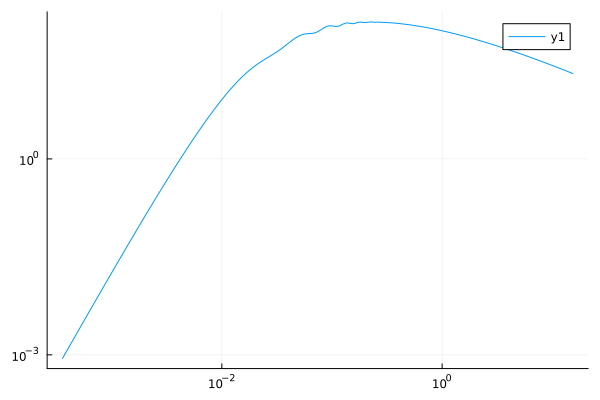

In [17]:
plot(k, k2_ps.(k), xscale=:log10, yscale=:log10)

In [18]:
Cl_gg = zeros(length(brute_ell))

for (il, l) in enumerate(brute_ell)
    Ig = AkimaInterpolation(G_l_k[il,:], k, extrapolate=true)
    integral, error = quadgk(x-> k2_ps(x)*Ig(x)*Ig(x), k[1], k[end])
    Cl_gg[il] = integral.*2 ./π.*factor_g(l).*factor_g(l)
end

npzwrite("brute_force/Cl_gg.npy", Cl_gg)

In [19]:
Cl_gs = zeros(length(brute_ell))

for (il, l) in enumerate(brute_ell)
    Ig = AkimaInterpolation(G_l_k[il,:], k, extrapolate=true)
    Is = AkimaInterpolation(S_l_k[il,:], k, extrapolate=true)
    integral, error = quadgk(x-> k2_ps(x)*Ig(x)*Is(x), k[1], k[end])
    Cl_gs[il] = integral.*2 ./π.*factor_g(l).*factor_s(l)
end

npzwrite("brute_force/Cl_gs.npy", Cl_gs)

In [20]:
Cl_ss = zeros(length(brute_ell))

for (il, l) in enumerate(brute_ell)
    Is = AkimaInterpolation(S_l_k[il,:], k, extrapolate=true)
    integral, error = quadgk(x-> k2_ps(x)*Is(x)*Is(x), k[1], k[end])
    Cl_ss[il] = integral.*2 ./π.*factor_s(l).*factor_s(l)
end

npzwrite("brute_force/Cl_ss.npy", Cl_ss)

In [21]:
Cl_gk = zeros(length(brute_ell))

for (il, l) in enumerate(brute_ell)
    Ig = AkimaInterpolation(G_l_k[il,:], k, extrapolate=true)
    Ik = AkimaInterpolation(CMB_l_k[il,:], k, extrapolate=true)
    integral, error = quadgk(x-> k2_ps(x)*Ig(x)*Ik(x), k[1], k[end])
    Cl_gk[il] = integral.*2 ./π.*factor_g(l).*factor_cmb(l)
end

npzwrite("brute_force/Cl_gk.npy", Cl_gk)

In [22]:
Cl_sk = zeros(length(brute_ell))

for (il, l) in enumerate(brute_ell)
    Is = AkimaInterpolation(S_l_k[il,:], k, extrapolate=true)
    Ik = AkimaInterpolation(CMB_l_k[il,:], k, extrapolate=true)
    integral, error = quadgk(x-> k2_ps(x)*Is(x)*Ik(x), k[1], k[end])
    Cl_sk[il] = integral.*2 ./π.*factor_s(l).*factor_cmb(l)
end

npzwrite("brute_force/Cl_sk.npy", Cl_sk)

## 